In [9]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler
from cldm.cldm import ControlLDM

from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [10]:
apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [11]:
def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results

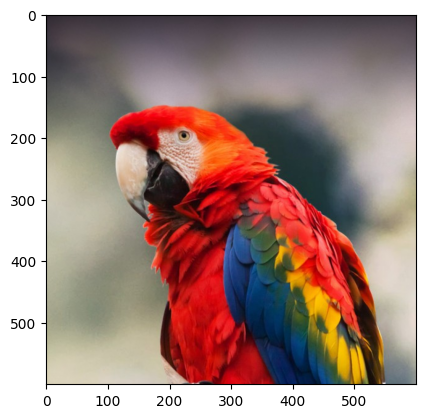

In [12]:
input_image = load_image(
    "https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg"
)
plt.imshow(input_image)
input_image = np.array(input_image)

Global seed set to 50


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler:   5%|███████                                                                                                                                     | 1/20 [00:00<00:02,  7.25it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  10%|██████████████                                                                                                                              | 2/20 [00:00<00:02,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  20%|████████████████████████████                                                                                                                | 4/20 [00:00<00:02,  7.27it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  25%|███████████████████████████████████                                                                                                         | 5/20 [00:00<00:02,  7.27it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  35%|█████████████████████████████████████████████████                                                                                           | 7/20 [00:00<00:01,  7.27it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  40%|████████████████████████████████████████████████████████                                                                                    | 8/20 [00:01<00:01,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 10/20 [00:01<00:01,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 11/20 [00:01<00:01,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13/20 [00:01<00:00,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14/20 [00:01<00:00,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 16/20 [00:02<00:00,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17/20 [00:02<00:00,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 19/20 [00:02<00:00,  7.26it/s]

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

DDIM Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.26it/s]


torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 4, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 64, 64])
0 torch.Size([1, 320, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 32, 32])
0 torch.Size([1, 640, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 16, 16])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
0 torch.Size([1, 1280, 8, 8])
1 before: torch.Size([1, 2560, 8, 8])
1 after: torch.Size([1, 1280, 8, 8])
2 before: torch.Size([1, 2560, 8, 8]

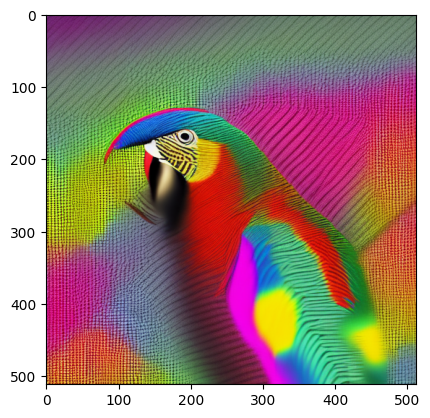

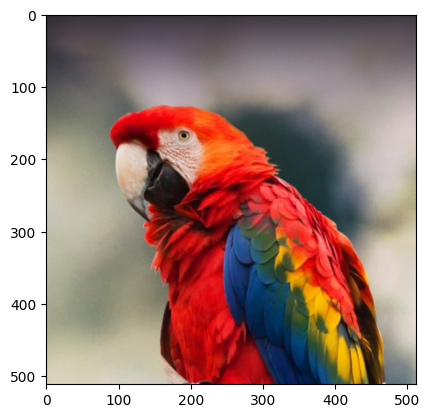

In [13]:
image_resolution = 512
low_threshold = 100
high_threshold = 200
num_samples = 1
seed = 50
prompt = "a photo of a colorful parrot"
a_prompt = ""
n_prompt = "blurry"
guess_mode = False
strength = 1
ddim_steps = 20
eta = 0
scale = 9

img = resize_image(HWC3(input_image), image_resolution)
H, W, C = img.shape
detected_map = apply_canny(img, low_threshold, high_threshold)
detected_map = HWC3(detected_map)

detected_map = img

with torch.no_grad():
    
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()

    if seed == -1:
        seed = random.randint(0, 65535)
    seed_everything(seed)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
    un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
    samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=eta,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    results = [x_samples[i] for i in range(num_samples)]
plt.imshow(results[0])
plt.show()
plt.imshow(detected_map)
plt.show()

In [41]:
for i in range(len(intermediates['x_inter'])):
    print(intermediates['x_inter'][i].shape)
    x_samples = model.decode_first_stage(intermediates['x_inter'][i])
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    results = [x_samples[i] for i in range(num_samples)]
    image = Image.fromarray(results[0])
    image.save("image_iter_" + str(i) + ".png")
for i in range(len(intermediates['pred_x0'])):
    print(intermediates['pred_x0'][i].shape)
    x_samples = model.decode_first_stage(intermediates['pred_x0'][i])
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    results = [x_samples[i] for i in range(num_samples)]
    image = Image.fromarray(results[0])
    image.save("image_pred" + str(i) + ".png")

torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])


In [14]:
control.shape

torch.Size([1, 3, 512, 512])

In [15]:
un_cond['c_concat'][0].shape, un_cond['c_crossattn'][0].shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 77, 768]))

In [16]:
samples.shape

torch.Size([1, 4, 64, 64])

In [17]:
type(model)

cldm.cldm.ControlLDM

In [18]:
# model.model.diffusion_model
# model.control_model

# 理解代码

In [19]:
from ldm.models.diffusion.ddpm import LatentDiffusion
import torch
from omegaconf import OmegaConf

In [20]:
# 读取config
config = OmegaConf.load(f"./models/cldm_v15.yaml")
config
model_v15_original = ControlLDM(**config.model.get("params", dict())).cpu()
# Controlnet checkpoint
# x = load_state_dict('./models/control_sd15_canny.pth', location='cuda')
# print(x.keys())
model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [14]:
import numpy as np
npzfile = np.load("test_controlnet.npz")
print(npzfile.files)
x_noisy = torch.tensor(npzfile["x_noisy"]).to(device='cuda')
hint = torch.tensor(npzfile["hint"]).to(device='cuda')
context = torch.tensor(npzfile["context"]).to(device='cuda')
timestep = torch.tensor(npzfile["timestep"]).to(device='cuda')

['x_noisy', 'hint', 'context', 'timestep']


In [15]:
model.control_model(x_noisy, hint,timestep, context)[0].shape

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])


torch.Size([1, 320, 64, 64])

In [16]:
# !  pip install torchviz
# !pip install torchinfo
# !pip install scipy
# !which python
# !/home/ubuntu/anaconda3/envs/control/bin/pip install scipy
# !/home/ubuntu/anaconda3/envs/control/bin/pip install netron

In [17]:
import netron
model_data = "./models/control_sd15_canny.pth"
netron.start(model_data)

Serving './models/control_sd15_canny.pth' at http://localhost:8080


('localhost', 8080)

In [18]:
from tensorwatch import draw_model
draw_model(model.control_model, input_data={"x":x_noisy, "hint":hint, "timesteps":timestep, "context":context}, dtypes=[torch.float, torch.float, torch.int, torch.float])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   1 from tensorwatch import draw_model                                                           │
│ ❱ 2 draw_model(model.control_model, input_data={"x":x_noisy, "hint":hint, "timesteps":timest     │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: draw_model() got an unexpected keyword argument 'input_data'

In [19]:
import torchvision.models as models
from torchinfo import summary
summary(model.control_model, input_data={"x":x_noisy, "hint":hint, "timesteps":timestep, "context":context}, dtypes=[torch.float, torch.float, torch.int, torch.float])

torch.Size([1, 3, 512, 512])
torch.Size([1, 320, 64, 64])
torch.Size([1, 4, 64, 64])
1
torch.Size([1, 320, 64, 64])
2
torch.Size([1, 320, 64, 64])
3
torch.Size([1, 320, 64, 64])
4
torch.Size([1, 320, 32, 32])
5
torch.Size([1, 640, 32, 32])
6
torch.Size([1, 640, 32, 32])
7
torch.Size([1, 640, 16, 16])
8
torch.Size([1, 1280, 16, 16])
9
torch.Size([1, 1280, 16, 16])
10
torch.Size([1, 1280, 8, 8])
11
torch.Size([1, 1280, 8, 8])
12
torch.Size([1, 1280, 8, 8])


Layer (type:depth-idx)                                                 Output Shape              Param #
ControlNet                                                             [1, 320, 64, 64]          --
├─Sequential: 1-1                                                      [1, 1280]                 --
│    └─Linear: 2-1                                                     [1, 1280]                 410,880
│    └─SiLU: 2-2                                                       [1, 1280]                 --
│    └─Linear: 2-3                                                     [1, 1280]                 1,639,680
├─TimestepEmbedSequential: 1-2                                         [1, 320, 64, 64]          --
│    └─Conv2d: 2-4                                                     [1, 16, 512, 512]         448
│    └─SiLU: 2-5                                                       [1, 16, 512, 512]         --
│    └─Conv2d: 2-6                                                     [1, 16, 512

In [20]:
# !pip install tensorwatch